In [1]:
#Graph Dists
from graph_distances.competing_methods import getEVdist, getDegreedist, getG2V_dist, getNodeEmbeddingdist, getGOT
from our_external_pypi_package.prob_OT import getOT

#Benchmark
from benchmark import knn
import time

#Plotting
from tools.plotting import plot_heatmap, hier_clustering, plot_emb
import seaborn as sns
import matplotlib.pyplot as plt

#External Packages
import networkx as nx
import numpy as np
import pandas as pd
import random

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

### Load Dataset

In [2]:
### Paper
n_trials = 200
dataset = "response_GN06.npy" #"FC_GN06_Covs_t1.npy" #

#Trials, labels, phase, cond = ot_lib.load(dataset,trial_mean=False,time_mean=True,squeeze=False,time_slice=slice(None),trials_slice=slice(0,n_trials,1),drop=['LR-RS','RR-LS','FC_phase~posttrial', 'FC_phase~delay']) 
 
#Trials = [nx.to_numpy_array(g) for g in Trials]
#FC_networks = Trials
FC_dataset = np.load("/home/kuehn/CNP_OT_clean/cnp-ot/data/networks/FC/response_GN06.npz")
Trials, labels, phase, cond  = FC_dataset["FC_networks"], FC_dataset["labels"], FC_dataset["phase"],FC_dataset["cond"]

### Set Parameters for CNP and CCB

In [4]:
#FC_networks = Trials
#np.savez_compressed("/home/kuehn/CNP_OT_clean/cnp-ot/data/networks/FC/response_GN06",FC_networks=FC_networks,labels=labels,phase=phase,cond=cond)


#Params for CNP and CBB
i = 1000 #i instantiations: the number of sampled colorings
k = 10 #k colors: the number of different colors randomily assigned to nodes
d = 5 #d depth: the number of steps A^d from each node

#Number of threads for parallel processing (when supported by method)
n_cpus = 50

#This will include GOT, Role2Vec, Node2Vec and the Covariance-based CNP & CCB OT for the comparison but increases runtime of benchmark significantly!
include_slow_methods = True
slow_methods = ["Role2vec-GW","Node2vec-GW","GOT","CNP-ScaledW","CCB-ScaledW","CNP-FullW","CCB-FullW"]

### Setup all methods for comparison

In [5]:
path = "../data/results/" 
name = "FunctionalConnectivity_Computed"
precomputed_dists,plans,times = {},{},{}
if True:
    precomputed_dists =  np.load(path+name+"Dists.npy",allow_pickle=True).tolist()
    #np.save(path+name+"plans.npy",plans) 
    times = np.load(path+name+"Times.npy",allow_pickle=True).tolist()
    print(precomputed_dists)


methods =  {
    #Euclidean Dists
    "Degree": (lambda G1,G2: getDegreedist(G1,G2)),
    "EV": (lambda G1,G2: getEVdist(G1,G2)),
    "Graph2Vec": (lambda G1,G2: getG2V_dist(G1,dim=(64 * k * d))),
    
    #Gromov-Wasserstein Dists
    "Role2vec-GW":(lambda G1,G2: getNodeEmbeddingdist(G1, G2, embedding_name='role2vec', D_dimensions=(k * d),distance='gw')),
    "Role2vec-GW_parallel":(lambda G1,G2: getOT(G1,G2, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="role2vec",distance='gw')),
    
    "Node2Vec-GW":(lambda G1,G2: getNodeEmbeddingdist(G1, G2, embedding_name='node2vec', D_dimensions=(k * d),distance='gw')),
    "Node2Vec-GW_parallel":(lambda G1,G2: getOT(G1,G2, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1,num_workers=n_cpus,embedding_method="node2vec",distance='gw')),
    
    #Wasserstein Dists.
    #"GOT": (lambda G1,G2: getGOT(G1,G2,dist='GOT')),

    "CNP-TiedW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None )),
    "CCB-TiedW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None )),
    
    "CNP-ScaledW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='scaled')), 
    "CCB-ScaledW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='scaled')),

    "CNP-FullW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=True, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='full')), 
    "CCB-FullW": (lambda G1,G2: getOT(G1,G2,Features=None,i_instatiations=i, k_colors=k, d_depth=d, D_dimensions=None, normalized=True, row_normalized=True, sort=False, alpha=1.,num_workers=n_cpus,scale_multiple_costs=None,covariance='full')),    
    }

#Filter out slow methods if not selected for comparison
methods = {m: methods[m] for m in methods.keys() if (m not in slow_methods or include_slow_methods)}

{'Degree': array([[ 0.        , 65.47508444, 34.92359231, ..., 39.72204336,
        44.40013182, 35.59503842],
       [65.47508444,  0.        , 31.19093751, ..., 26.58695419,
        21.79903138, 31.70471691],
       [34.92359231, 31.19093751,  0.        , ...,  8.29530068,
        11.58226866, 10.35748662],
       ...,
       [39.72204336, 26.58695419,  8.29530068, ...,  0.        ,
         8.25692574,  8.36768874],
       [44.40013182, 21.79903138, 11.58226866, ...,  8.25692574,
         0.        , 11.27085793],
       [35.59503842, 31.70471691, 10.35748662, ...,  8.36768874,
        11.27085793,  0.        ]]), 'EV': array([[0.00000000e+00, 2.67935967e-03, 1.29208995e-02, ...,
        2.67935967e-03, 2.03210591e-01, 1.53490202e-01],
       [2.67935967e-03, 0.00000000e+00, 1.49184595e-02, ...,
        1.72777065e-16, 2.05103974e-01, 1.56075013e-01],
       [1.29208995e-02, 1.49184595e-02, 0.00000000e+00, ...,
        1.49184595e-02, 1.93381200e-01, 1.43377417e-01],
       ...,
   

### Compute all pairwise graph distances with the respective methods

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


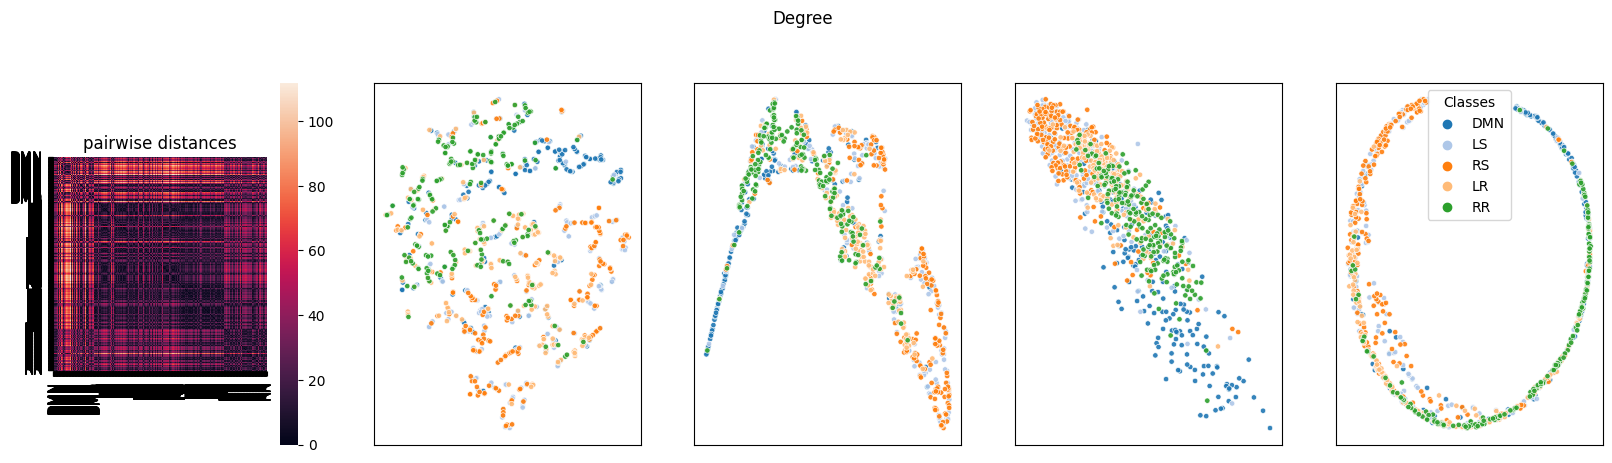

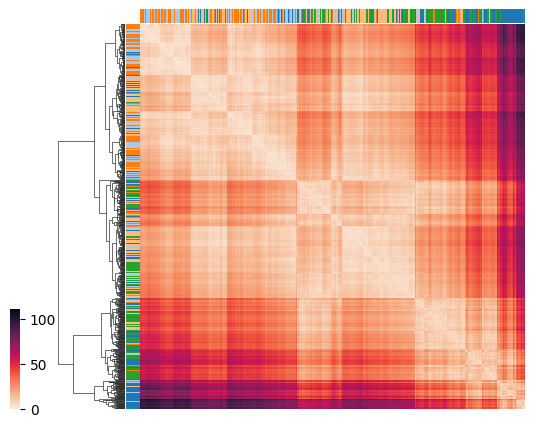

/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/graphtools/graphs.py:1039: RuntimeWarning: overflow encountered in power
  K = np.exp(-1 * np.power(pdx, self.decay))


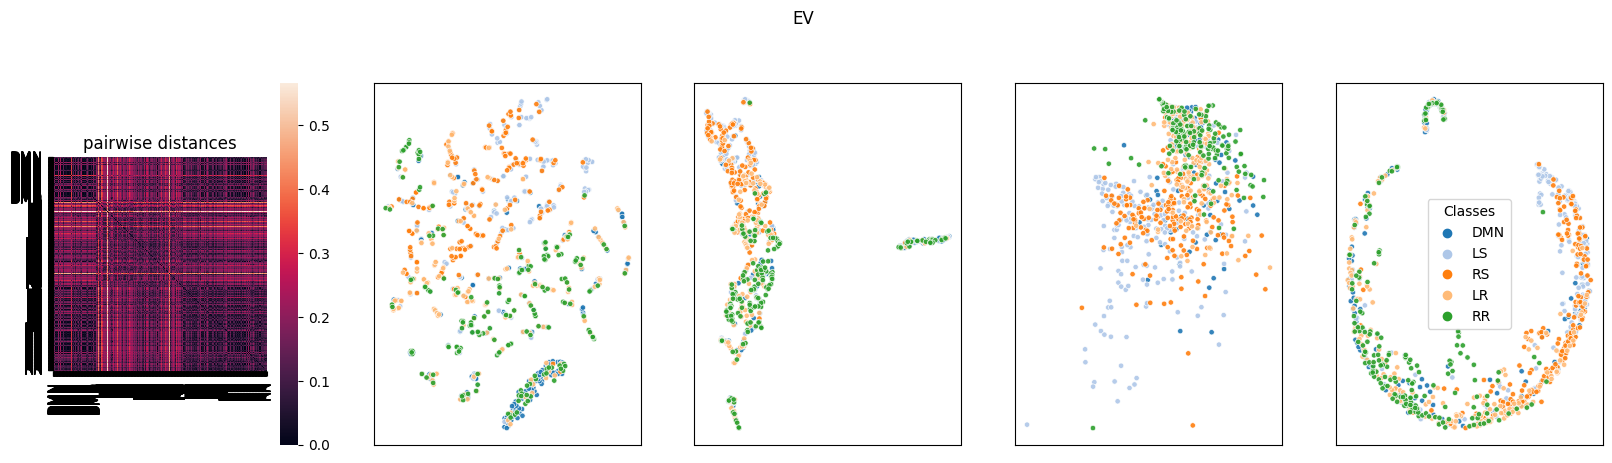

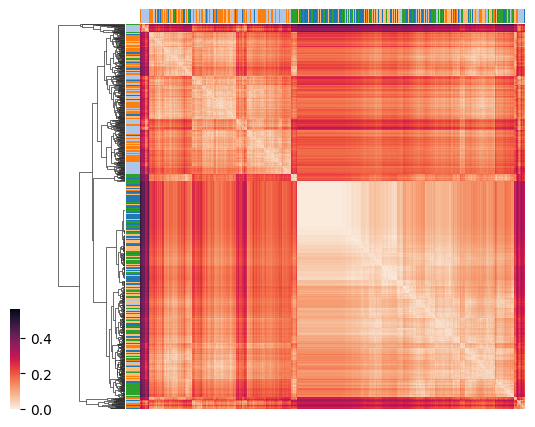

100%|██████████| 1000/1000 [00:02<00:00, 430.21it/s]


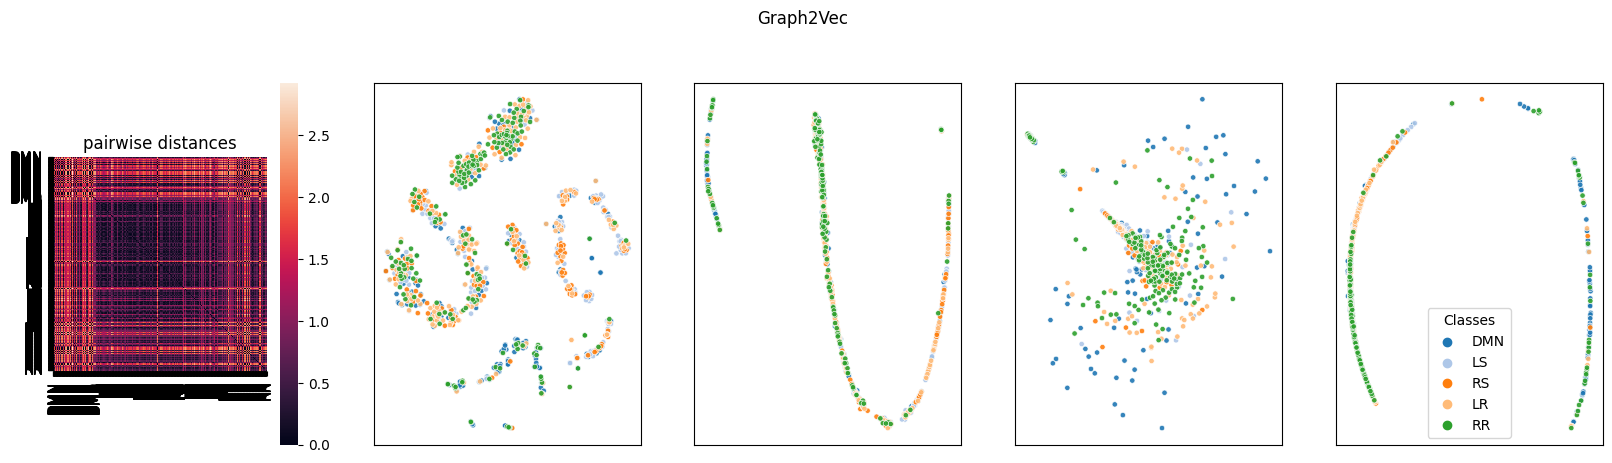

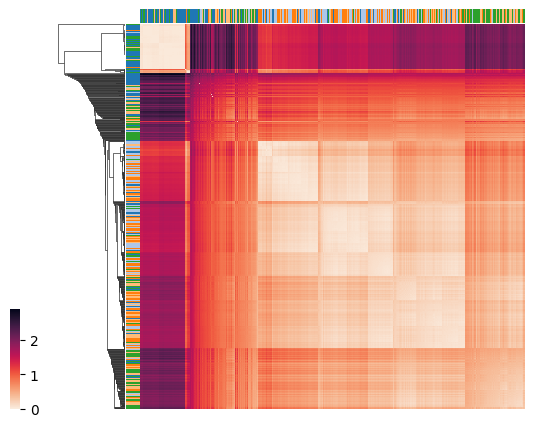

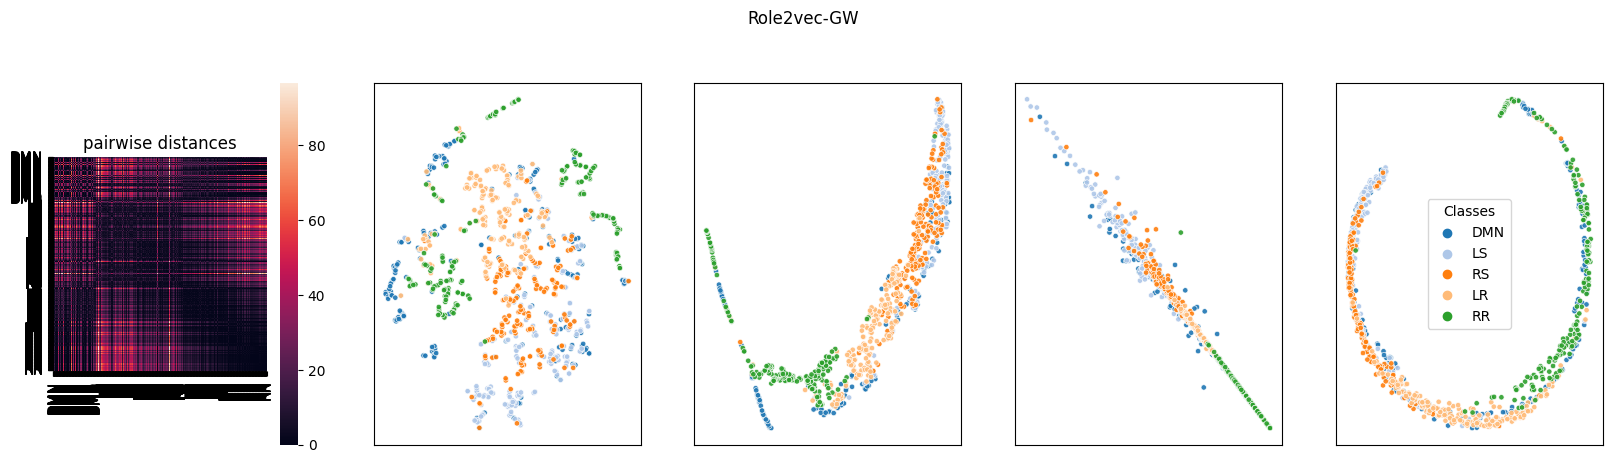

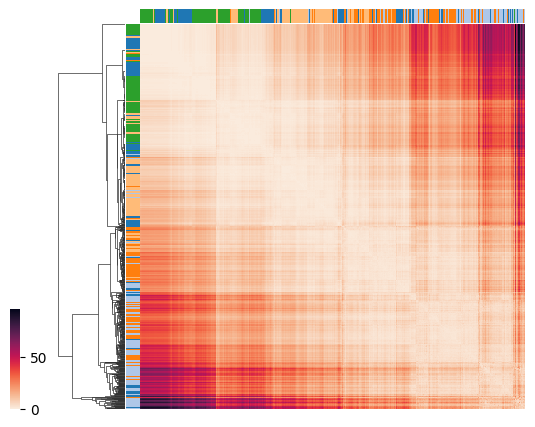

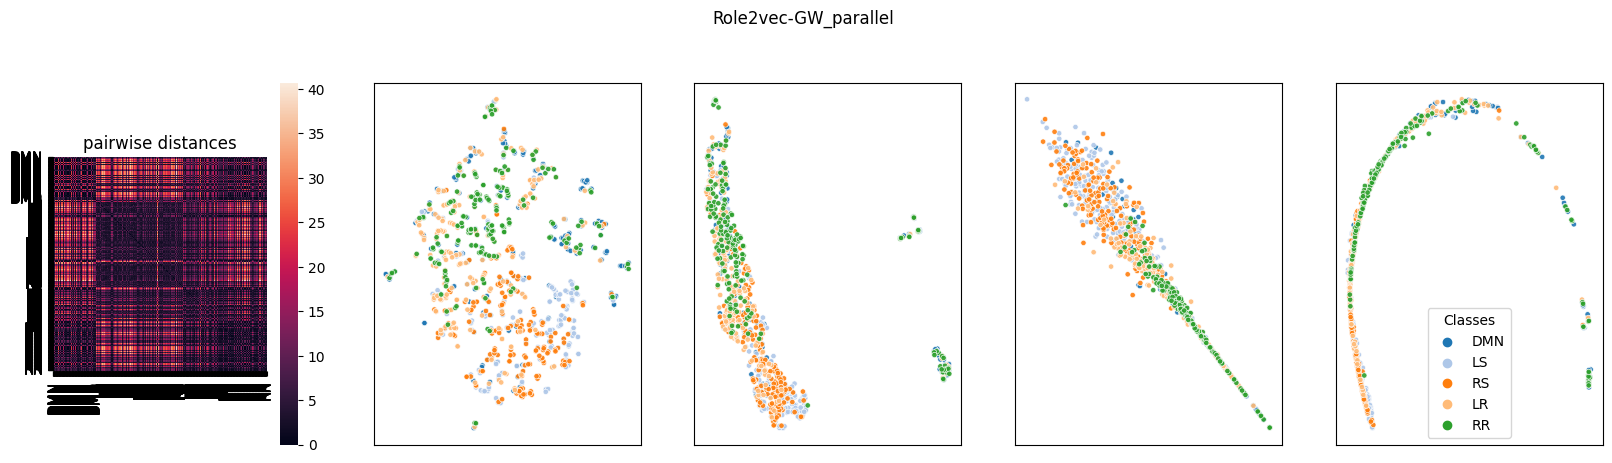

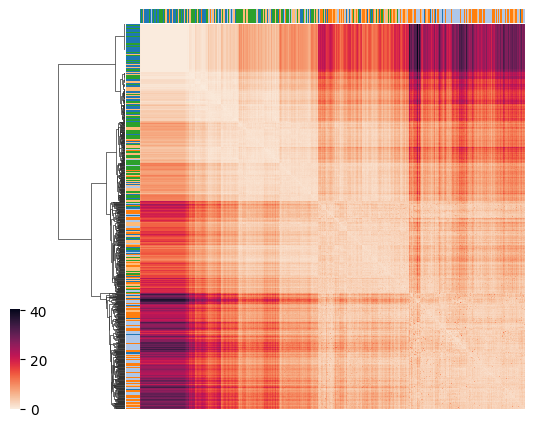

In [6]:
%load_ext autoreload
%autoreload 2
    
time_limit = 60
for method, func in methods.items():
    if times.get(method, 0) < time_limit:
        st = time.time()
        precomputed_dists[method], plans[method], _ , _ = func(Trials.copy(),None)
        et = time.time()
        times[method] = et - st
        precomputed_dists[method][precomputed_dists[method]<0] = 0

    fig, axs = plt.subplots(1,5,figsize=(20,5))
    plot_heatmap(precomputed_dists[method],labels,ax=axs[0])
    plot_emb(precomputed_dists[method],method='tsne',colors=phase,ax=axs[1],legend=False,title="TSNE")
    plot_emb(precomputed_dists[method],method='umap',colors=phase,ax=axs[2],legend=False,title="UMAP")
    plot_emb(precomputed_dists[method],method='mds',colors=phase,ax=axs[3],legend=False,title="MDS")
    plot_emb(precomputed_dists[method],method='phate',colors=phase,ax=axs[4],legend=True,title="PHATE")
    fig.suptitle(method)

    hier_clustering(precomputed_dists[method],labels, ax=None)
    plt.show()


### Save computed distances 

In [ ]:
path = "../data/results/" 
name = "FunctionalConnectivity_Computed"

if True:
    np.save(path+name+"Dists.npy",precomputed_dists)
    np.save(path+name+"Times.npy",times)

### Weighted KNN over precomputed distances to benchmark competing methods

,KNN T=0.9,SC,Time
method,,,
Degree,0.53±0.03,-.071,0.00
EV,0.44±0.03,-.045,0.01
Graph2Vec,0.33±0.02,-.162,0.03
Role2vec-GW,0.77±0.03,.041,14.24
Role2vec-GW_parallel,0.54±0.03,-.102,1.10


\begin{tabular}{llll}
\toprule
 & KNN T=0.9 & SC & Time \\
method &  &  &  \\
\midrule
Degree & 0.53±0.03 & -.071 &  0.00 \\
EV & 0.44±0.03 & -.045 &  0.01 \\
Graph2Vec & 0.33±0.02 & -.162 &  0.03 \\
Role2vec-GW & 0.77±0.03 & .041 &  14.24 \\
Role2vec-GW_parallel & 0.54±0.03 & -.102 &  1.10 \\
\bottomrule
\end{tabular}



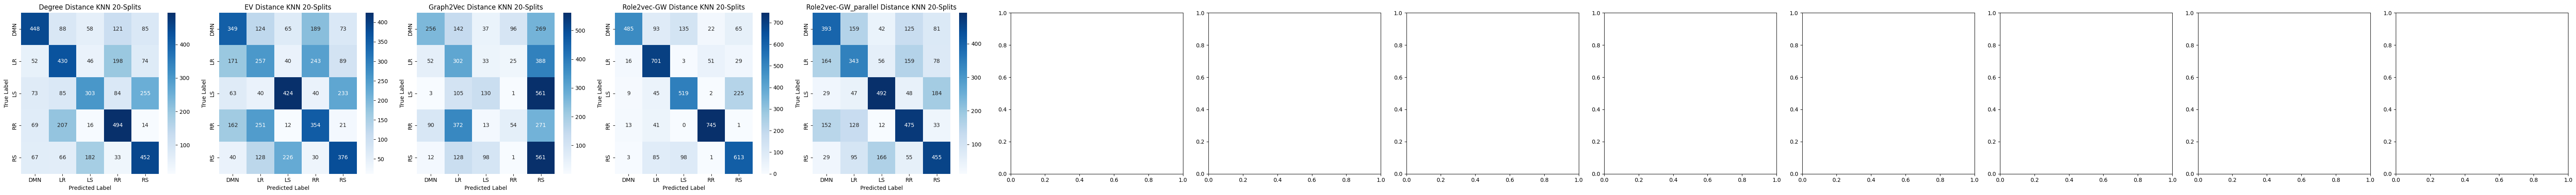

In [ ]:
fig, axs = plt.subplots(1,len(methods.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)
results = {"method":[],
           "KNN T=0.9":[],
           "SC":[],
           #"ARI":[],
           "Time":[]}

for m, (method, dist) in enumerate(precomputed_dists.items()):
    pred, true, score, ari = knn.from_dists(Trials,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.2,n_splits=20,n_neighbors=5)
    knn.plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #zero_dia_dists = precomputed_dists[method]
    #np.fill_diagonal(zero_dia_dists,0)
    #sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")
    sil = knn.silhouette_score_wrapper(precomputed_dists[method],labels)

    #ari = adjusted_rand_score(true,np.concatenate(pred))

    results["method"].append(method)
    results["KNN T=0.9"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")
    #results["ARI"].append(f"{np.average(ari):.2f}±{np.std(ari):.2f}")
    results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    results["Time"].append(f"{times[method]/(len(Trials)*(len(Trials)-1)/2) * 1000: .2f}")

fig.tight_layout()
knn.plot_table(pd.DataFrame(results))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


/home/kuehn/CNP_OT/cnp-ot/paper/figures/exp1/12tmp_log_mice_CCB-TiedW_serial_UMAP.pdf


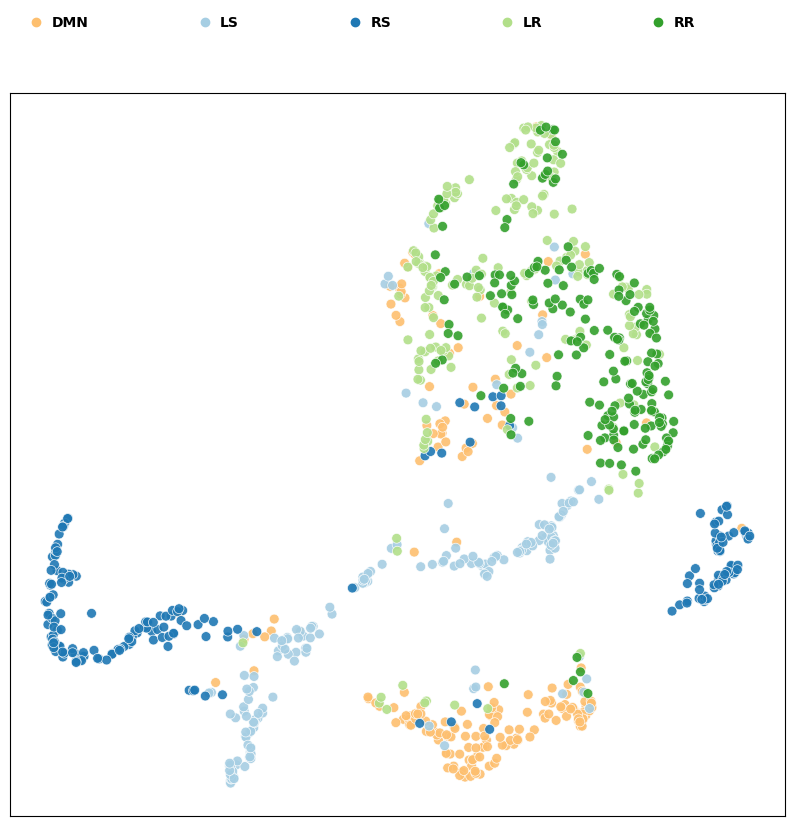

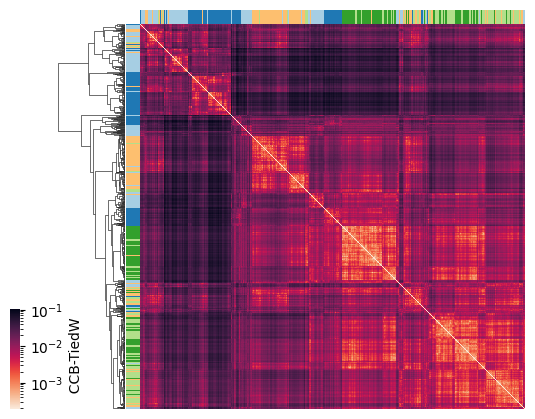

In [ ]:
%load_ext autoreload
%autoreload 2
save_folder = "/home/kuehn/CNP_OT/cnp-ot/paper/figures/exp1/12tmp_" 


for m, (method, func) in enumerate(methods.items()):
#if True:
    #method="CCB-TiedW"

    
    #ordered_labels = np.roll(np.copy(labels),-200) #[200:] + labels[:200]
    #ordered_dists = np.copy(precomputed_dists[method])
    #ordered_dists = np.roll(ordered_dists,-200,axis=(0,1))


    #ordered_dists[:800,:800] = precomputed_dists[method][200:,200:] 
    #ordered_dists[800:,:] = precomputed_dists[method][:200,:] 
    #ordered_dists[:,800:] = precomputed_dists[method][:,:200] 

    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=True,save_path=f"{save_folder}/log_mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=True,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}_cluster.png",cmap='tab20')

    colors = sns.color_palette("Paired") #palette=cmap,n_colors=len(unique_labels))
    cmap_dict = dict(LS=colors[0], RS=colors[1], LR=colors[2], RR=colors[3], DMN=colors[6]) 

    plot_emb(precomputed_dists[method],s=50,method='umap',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}log_mice_{method}_UMAP.pdf",cmap=cmap_dict)
    fig = hier_clustering(precomputed_dists[method], labels, ax=None, cluster=True,title="",dist_name="  CCB-TiedW",log=True,save_path=f"{save_folder}log_mice_{method}_cluster.pdf",cmap=cmap_dict)
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=True,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/hier_clust_left.right.mice_{method}.pdf")

In [ ]:
%load_ext autoreload
%autoreload 2
for method, dist in precomputed_dists.items():
    if method!="TiedOTCooper":
        continue
    #hier_clustering(dists[method],Labels, ax=None, cluster=False)
    dist = np.copy(dist)
    dist[dist>0] = np.log(dist[dist>0]+1)
    fig, axs = plt.subplots(1,5,figsize=(20,5))
    plot_heatmap(dist,labels,ax=axs[0])
    #plot_emb(dists[method],method='umap',colors=phase,symbols=cond)
    plot_emb(dist,method='tsne',colors=phase,symbols=cond,cmap='tab20')#,ax=axs[1])
    plot_emb(dist,method='umap',colors=phase,symbols=cond,cmap='tab20')#,ax=axs[2])
    plot_emb(dist,method='mds',colors=phase,symbols=cond,cmap='tab20')#,ax=axs[3])
    plot_emb(dist,method='phate',colors=phase,symbols=cond,cmap='tab20')#,ax=axs[4])
    fig.suptitle(method)
    plt.show()

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
